In [1]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch import nn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

import ipdb
from tqdm.notebook import tqdm
print(torch.__version__)


2.0.1+cu117


# **Loading and Preprocessing CIFAR-10 Dataset**

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [3]:
data_path = '../data_cifar/'
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Training: ", len(cifar10_train))
print("Testing: ", len(cifar10_test))

Training:  50000
Testing:  10000


In [5]:
torch.manual_seed(80)
train_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=100, shuffle=False)

In [6]:
for images, labels in train_loader:
  break
images.shape

torch.Size([32, 3, 32, 32])

# **Building ANN Model**

In [7]:
class Network(nn.Module):
    def __init__(self, input_size = 32*32*3 , output_size = 10):
        super(Network,self).__init__()
        
        self.input_hidden1 = nn.Linear(input_size, 4096)
        self.hidden1_hidden2 = nn.Linear(4096, 2048)
        self.hidden2_hidden3 = nn.Linear(2048, 512)
        self.hidden3_output = nn.Linear(512, output_size)
        
       
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = torch.relu(self.input_hidden1(x))
        x = torch.relu(self.hidden1_hidden2(x))
        x = torch.relu(self.hidden2_hidden3(x))
        x = self.hidden3_output(x)
    
        return x

In [8]:
torch.manual_seed(80)
model = Network()
model

Network(
  (input_hidden1): Linear(in_features=3072, out_features=4096, bias=True)
  (hidden1_hidden2): Linear(in_features=4096, out_features=2048, bias=True)
  (hidden2_hidden3): Linear(in_features=2048, out_features=512, bias=True)
  (hidden3_output): Linear(in_features=512, out_features=10, bias=True)
)

## **Training the Model**

In [9]:
loss_fn = nn.CrossEntropyLoss()

def get_test_stat(model, dl, device):
    model.eval()    # set model to eval mode
    cum_loss, cum_acc = 0.0, 0.0
    for i, (xb, yb) in enumerate(dl):
        xb = xb.to(device)
        yb = yb.to(device)

        xb = xb.view(xb.size(0), -1)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        cum_loss += loss.item() * len(yb)
        cum_acc += acc.item() * len(yb)
    cum_loss /= 10000
    cum_acc /= 10000
    model.train()   # set model back to train mode
    return cum_loss, cum_acc

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [10]:
learning_rate = 1e-2
epochs = 10 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"
print(device)
    
model.to(device)
model.train()

train_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
test_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}

pbar = tqdm(range(epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch {epoch + 1} / 10")
    train_loss = 0.0
    train_acc = 0.0
    for i, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        xb = xb.view(xb.size(0), -1)

        # Forward pass
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        # Backward pass
        model.zero_grad()  # Zero out the previous gradient computation
        loss.backward()    # Compute the gradient
        optimizer.step()   # Use the gradient information to make a step
        train_stats['epoch'].append(epoch + i / len(train_loader))
        train_stats['loss'].append(loss.item())
        train_stats['acc'].append(acc.item())
    test_loss, test_acc = get_test_stat(model, test_loader, device)
    test_stats['epoch'].append(epoch + 1)
    test_stats['loss'].append(test_loss)
    test_stats['acc'].append(test_acc)
    print ('Epoch: ', epoch, ' Loss = ', test_loss, ' Accuracy = ', test_acc)


Using cuda
cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0  Loss =  1.6117275869846344  Accuracy =  0.4199999883770943
Epoch:  1  Loss =  1.4910887837409974  Accuracy =  0.473699988424778
Epoch:  2  Loss =  1.4186816096305848  Accuracy =  0.49759998738765715
Epoch:  3  Loss =  1.36743475317955  Accuracy =  0.5152999836206437
Epoch:  4  Loss =  1.3809034740924835  Accuracy =  0.5194999858736992
Epoch:  5  Loss =  1.3467048281431198  Accuracy =  0.532599987089634
Epoch:  6  Loss =  1.4011673188209535  Accuracy =  0.5243999871611595
Epoch:  7  Loss =  1.413742458820343  Accuracy =  0.5227999871969223
Epoch:  8  Loss =  1.4401226007938386  Accuracy =  0.5293999871611595
Epoch:  9  Loss =  1.4419738888740539  Accuracy =  0.5426999855041504


In [11]:
model_out_path = "model.pth"
torch.save(model, model_out_path)
print("Checkpoint saved to {}".format(model_out_path))

Checkpoint saved to model.pth


## **Results and Analysis**

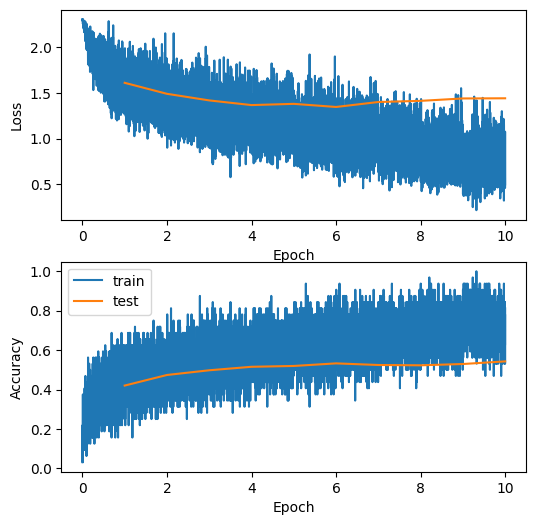

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
axes[0].plot(train_stats['epoch'], train_stats['loss'], label='train')
axes[0].plot(test_stats['epoch'], test_stats['loss'], label='test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].plot(train_stats['epoch'], train_stats['acc'], label='train')
axes[1].plot(test_stats['epoch'], test_stats['acc'], label='test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
images.view(-1, 3072).shape

torch.Size([32, 3072])

In [14]:
print(device)

cuda


In [46]:
# convert the tensor to 2 image
img = images[1].view(1, 3072)

# we are turning off the gradients (because we working forward path)
with torch.no_grad():
    model_prediction = model.forward(img.to(device))

In [47]:
#load all test data
test_load_all = DataLoader(cifar10_test, batch_size=10000, shuffle=False)

In [48]:

# function to Unnormalize the data so view the image
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.07894142 0.06823225 0.01486198 0.00902772 0.00735988 0.00164282
 0.00219133 0.00187213 0.5664938  0.24937664]


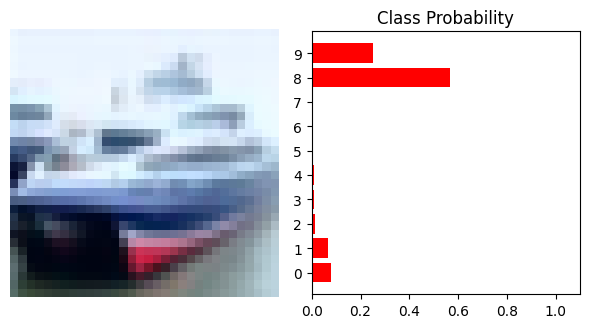

In [49]:
# plot the class probability of the chosen random image
import torch.nn.functional as F 

probabilities = F.softmax(model_prediction, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
curr_img = unnormalize(img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225]))
img = curr_img.view(3, 32, 32)
ax1.imshow(img.permute(1, 2, 0).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

In [19]:
# calculate the number of correctly predicted images with there accuracies
with torch.no_grad():
  print('Training:')
  correct = 0
  samples = 0
  for X_test, y_test in train_loader: 
    y_val = model(X_test.view(len(X_test),-1).to(device))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test.to(device)).sum()
    samples += predicted.size(0)
  print(
            f"Got {correct} from {samples} with accuracy"
            f" {float(correct) / float(samples) * 100:.2f}"
        )

with torch.no_grad():
  print('Test:')
  correct = 0
  samples = 0
  for X_test, y_test in test_load_all: 
    y_val = model(X_test.view(len(X_test),-1).to(device))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test.to(device)).sum()
    samples += predicted.size(0)
  print(
              f"Got {correct} from {samples} with accuracy"
              f" {float(correct) / float(samples) * 100:.2f}"
          )

Training:
Got 38740 from 50000 with accuracy 77.48
Test:
Got 5427 from 10000 with accuracy 54.27


In [20]:
100*correct.item()/len(cifar10_test)

54.27

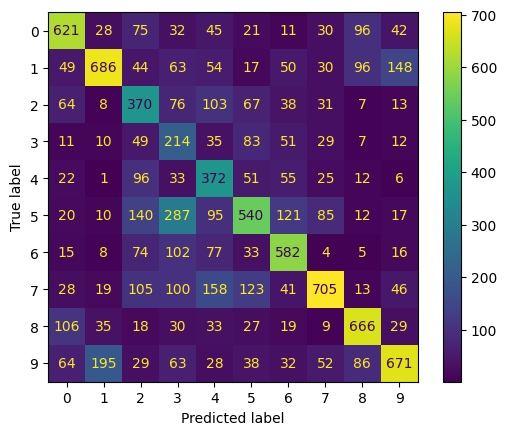

In [21]:
cm = confusion_matrix(predicted.view(-1).cpu(),y_test.view(-1))
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [22]:
#Model accuracy
report = classification_report(predicted.view(-1).cpu(),y_test.view(-1))
print(report)

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1001
           1       0.69      0.55      0.61      1237
           2       0.37      0.48      0.42       777
           3       0.21      0.43      0.29       501
           4       0.37      0.55      0.44       673
           5       0.54      0.41      0.46      1327
           6       0.58      0.64      0.61       916
           7       0.70      0.53      0.60      1338
           8       0.67      0.69      0.68       972
           9       0.67      0.53      0.59      1258

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.53     10000
weighted avg       0.58      0.54      0.55     10000



In [23]:
# load all test data 
test_load_all = DataLoader(cifar10_test, batch_size=81, shuffle=False)

In [24]:
images, labels = next(iter(test_load_all))

with torch.no_grad():
  images, labels = images, labels
  preds = model(X_test.view(len(X_test),-1).to(device))

images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = cifar10_test.classes

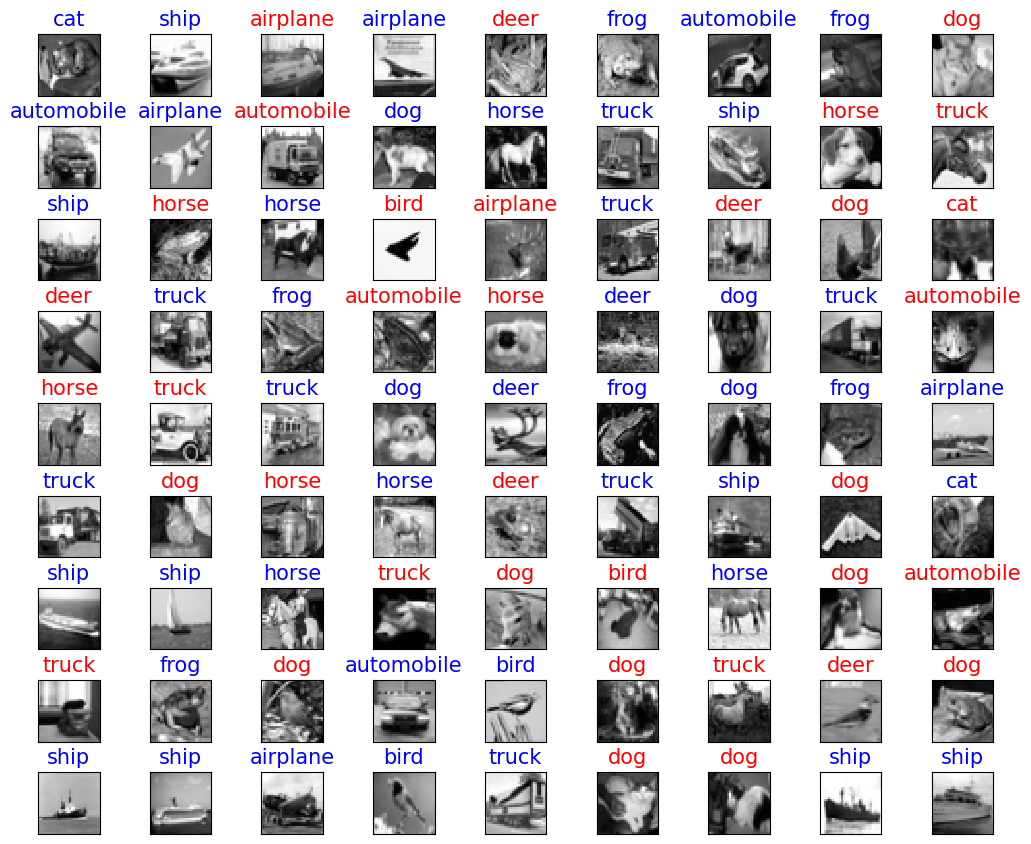

In [25]:
# plot test images with there label red if predicted incorrectly or blue if predicted correctly
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap='gray', interpolation='nearest')
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color, fontsize=15)

# **Building ANN with 2 hidden layers**

In [50]:
class Network2(nn.Module):
    def __init__(self, input_size = 32*32*3 , output_size = 10):
        super(Network2,self).__init__()
        
        self.input_hidden1 = nn.Linear(input_size, 292)
        self.hidden1_hidden2 = nn.Linear(292, 512)
        self.hidden2_output = nn.Linear(512, output_size)

        # Define sigmoid activation and softmax output 
        #self.sigmoid = nn.Sigmoid()
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = torch.relu(self.input_hidden1(x))
        x = torch.relu(self.hidden1_hidden2(x))
        x = self.hidden2_output(x)
    
        return x

In [51]:
torch.manual_seed(80)
model = Network2()
model

Network2(
  (input_hidden1): Linear(in_features=3072, out_features=292, bias=True)
  (hidden1_hidden2): Linear(in_features=292, out_features=512, bias=True)
  (hidden2_output): Linear(in_features=512, out_features=10, bias=True)
)

In [52]:
def get_test_stat(model, dl, device):
    model.eval()    # set model to eval mode
    cum_loss, cum_acc = 0.0, 0.0
    for i, (xb, yb) in enumerate(dl):
        xb = xb.to(device)
        yb = yb.to(device)

        xb = xb.view(xb.size(0), -1)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        cum_loss += loss.item() * len(yb)
        cum_acc += acc.item() * len(yb)
    cum_loss /= 10000
    cum_acc /= 10000
    model.train()   # set model back to train mode
    return cum_loss, cum_acc

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [53]:
learning_rate = 1e-2
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"
    
model.to(device)
model.train()

train_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
test_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}

pbar = tqdm(range(epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch {epoch + 1} / 10")
    train_loss = 0.0
    train_acc = 0.0
    for i, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        xb = xb.view(xb.size(0), -1)

        # Forward pass
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        # Backward pass
        model.zero_grad()  # Zero out the previous gradient computation
        loss.backward()    # Compute the gradient
        optimizer.step()   # Use the gradient information to make a step
        train_stats['epoch'].append(epoch + i / len(train_loader))
        train_stats['loss'].append(loss.item())
        train_stats['acc'].append(acc.item())

    test_loss, test_acc = get_test_stat(model, test_loader, device)
    test_stats['epoch'].append(epoch + 1)
    test_stats['loss'].append(test_loss)
    test_stats['acc'].append(test_acc)
    print ('Epoch: ', epoch, ' Loss = ', test_loss, ' Accuracy = ', test_acc)

Using cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0  Loss =  1.5588129210472106  Accuracy =  0.45159998774528504
Epoch:  1  Loss =  1.4767236995697022  Accuracy =  0.47909998655319214
Epoch:  2  Loss =  1.4020285677909852  Accuracy =  0.5051999855041504
Epoch:  3  Loss =  1.3878463435173034  Accuracy =  0.509999986588955
Epoch:  4  Loss =  1.392223825454712  Accuracy =  0.5058999848365784
Epoch:  5  Loss =  1.3476739716529846  Accuracy =  0.5309999892115593
Epoch:  6  Loss =  1.348737713098526  Accuracy =  0.5286999881267548
Epoch:  7  Loss =  1.361745216846466  Accuracy =  0.5286999872326851
Epoch:  8  Loss =  1.3631729918718338  Accuracy =  0.5290999865531921
Epoch:  9  Loss =  1.3777261793613433  Accuracy =  0.529099986255169


In [54]:
model_out_path = "model.pth"
torch.save(model, model_out_path)
print("Checkpoint saved to {}".format(model_out_path))

Checkpoint saved to model.pth


## **Results and Analysis**

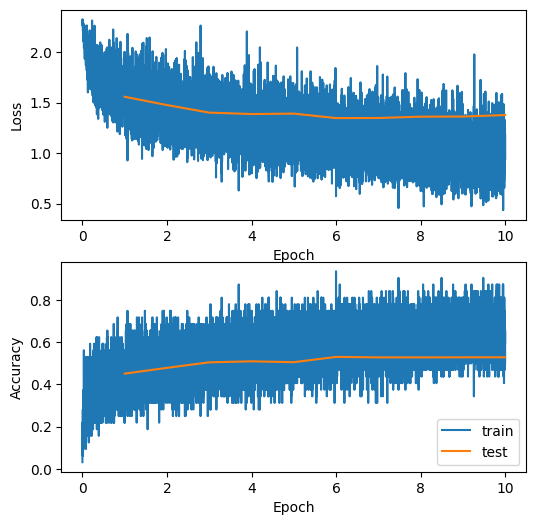

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
axes[0].plot(train_stats['epoch'], train_stats['loss'], label='train')
axes[0].plot(test_stats['epoch'], test_stats['loss'], label='test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].plot(train_stats['epoch'], train_stats['acc'], label='train')
axes[1].plot(test_stats['epoch'], test_stats['acc'], label='test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
images.view(-1, 3072).shape

torch.Size([81, 3072])

In [87]:
img = images[1].view(1, 3072)

# we are turning off the gradients
with torch.no_grad():
    model_prediction = model.forward(img.to(device))

In [88]:
test_load_all = DataLoader(cifar10_test, batch_size=10000, shuffle=False)

[1.34967435e-02 5.16406745e-02 2.92063225e-04 7.26735685e-04
 1.94352251e-04 6.94525224e-05 1.85632161e-04 6.88796426e-05
 8.44882190e-01 8.84431824e-02]


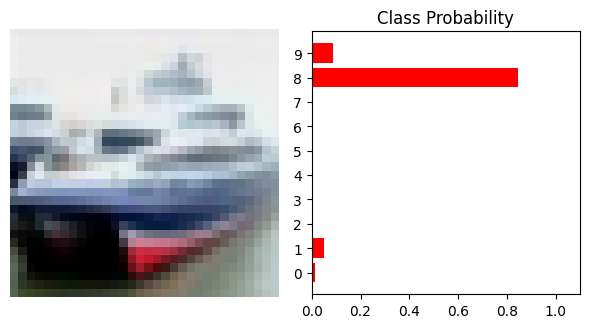

In [91]:
import torch.nn.functional as F 

probabilities = F.softmax(model_prediction, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
curr_img = unnormalize(img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225]))
img = curr_img.view(3, 32, 32)
ax1.imshow(img.permute(1, 2, 0).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

In [61]:
with torch.no_grad():
  print('Training:')
  correct = 0
  samples = 0
  for X_test, y_test in train_loader: 
    y_val = model(X_test.view(len(X_test),-1).to(device))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test.to(device)).sum()
    samples += predicted.size(0)
  print(
            f"Got {correct} from {samples} with accuracy"
            f" {float(correct) / float(samples) * 100:.2f}"
        )

with torch.no_grad():
  print('Test:')
  correct = 0
  samples = 0
  for X_test, y_test in test_load_all: 
    y_val = model(X_test.view(len(X_test),-1).to(device))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test.to(device)).sum()
    samples += predicted.size(0)
  print(
              f"Got {correct} from {samples} with accuracy"
              f" {float(correct) / float(samples) * 100:.2f}"
          )

Training:
Got 34411 from 50000 with accuracy 68.82
Test:
Got 5291 from 10000 with accuracy 52.91


In [62]:
100*correct.item()/len(cifar10_test)

52.91

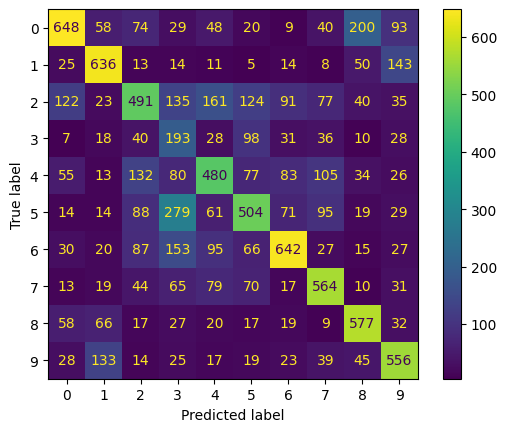

In [63]:
cm = confusion_matrix(predicted.view(-1).cpu(),y_test.view(-1))
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [64]:
#Model accuracy
report = classification_report(predicted.view(-1).cpu(),y_test.view(-1))
print(report)

              precision    recall  f1-score   support

           0       0.65      0.53      0.58      1219
           1       0.64      0.69      0.66       919
           2       0.49      0.38      0.43      1299
           3       0.19      0.39      0.26       489
           4       0.48      0.44      0.46      1085
           5       0.50      0.43      0.46      1174
           6       0.64      0.55      0.59      1162
           7       0.56      0.62      0.59       912
           8       0.58      0.69      0.63       842
           9       0.56      0.62      0.59       899

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.55      0.53      0.53     10000



In [65]:
test_load_all = DataLoader(cifar10_test, batch_size=81, shuffle=False)

In [66]:
images, labels = next(iter(test_load_all))

with torch.no_grad():
  images, labels = images, labels
  preds = model(X_test.view(len(X_test),-1).to(device))

images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = cifar10_test.classes

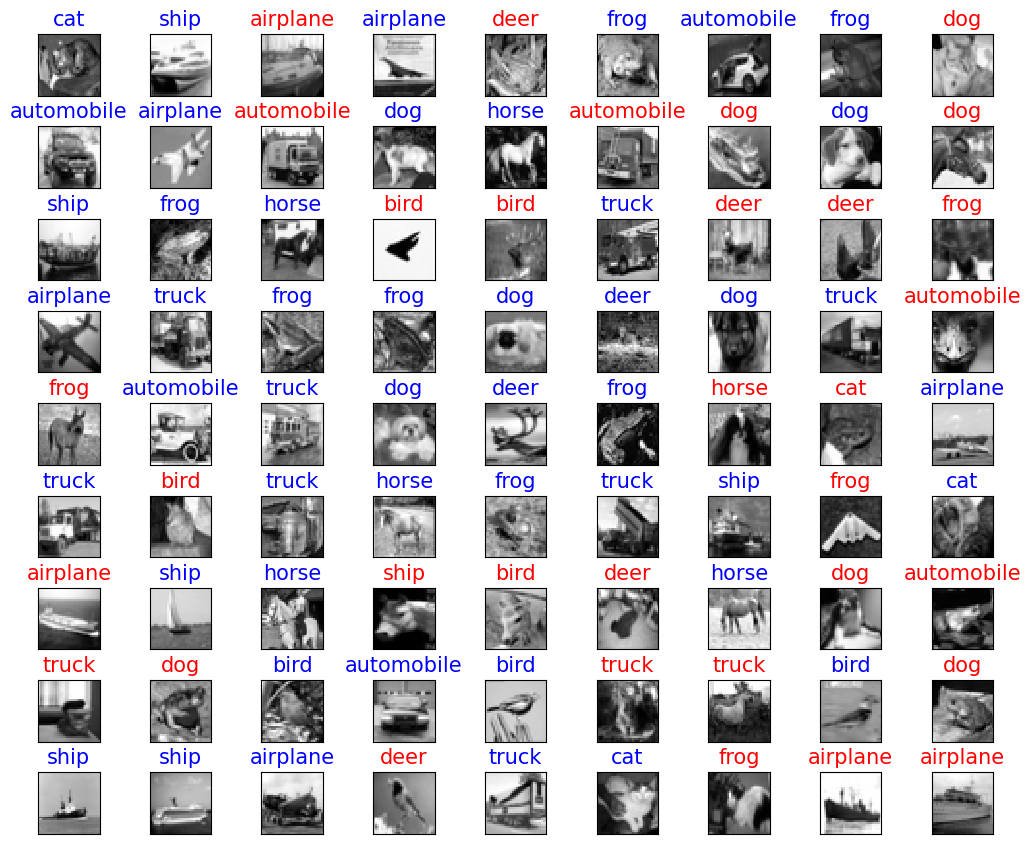

In [67]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap='gray', interpolation='nearest')
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color, fontsize=15)

# **Building ANN with 4 hidden layers**

In [68]:
class Network4(nn.Module):
    def __init__(self, input_size = 32*32*3, output_size = 10):
        super(Network4,self).__init__()
        
        self.input_hidden1 = nn.Linear(input_size, 292)
        self.hidden1_hidden2 = nn.Linear(292, 1023)
        self.hidden2_hidden3 = nn.Linear(1023, 4567)
        self.hidden3_hidden4 = nn.Linear(4567, 512)
        self.hidden4_output = nn.Linear(512, output_size)

        # Define sigmoid activation and softmax output 
        #self.sigmoid = nn.Sigmoid()
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = torch.relu(self.input_hidden1(x))
        x = torch.relu(self.hidden1_hidden2(x))
        x = torch.relu(self.hidden2_hidden3(x))
        x = torch.relu(self.hidden3_hidden4(x))
        x = self.hidden4_output(x)
    
        return x

In [69]:
model = Network4()
model

Network4(
  (input_hidden1): Linear(in_features=3072, out_features=292, bias=True)
  (hidden1_hidden2): Linear(in_features=292, out_features=1023, bias=True)
  (hidden2_hidden3): Linear(in_features=1023, out_features=4567, bias=True)
  (hidden3_hidden4): Linear(in_features=4567, out_features=512, bias=True)
  (hidden4_output): Linear(in_features=512, out_features=10, bias=True)
)

In [70]:
def get_test_stat(model, dl, device):
    model.eval()    # set model to eval mode
    cum_loss, cum_acc = 0.0, 0.0
    for i, (xb, yb) in enumerate(dl):
        xb = xb.to(device)
        yb = yb.to(device)

        xb = xb.view(xb.size(0), -1)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        cum_loss += loss.item() * len(yb)
        cum_acc += acc.item() * len(yb)
    cum_loss /= 10000
    cum_acc /= 10000
    model.train()   # set model back to train mode
    return cum_loss, cum_acc

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [71]:
learning_rate = 1e-2
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"
    
model.to(device)
model.train()

train_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
test_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}

pbar = tqdm(range(epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch {epoch + 1} / 10")
    train_loss = 0.0
    train_acc = 0.0
    for i, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        xb = xb.view(xb.size(0), -1)

        # Forward pass
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        # Backward pass
        model.zero_grad()  # Zero out the previous gradient computation
        loss.backward()    # Compute the gradient
        optimizer.step()   # Use the gradient information to make a step
        train_stats['epoch'].append(epoch + i / len(train_loader))
        train_stats['loss'].append(loss.item())
        train_stats['acc'].append(acc.item())

    test_loss, test_acc = get_test_stat(model, test_loader, device)
    test_stats['epoch'].append(epoch + 1)
    test_stats['loss'].append(test_loss)
    test_stats['acc'].append(test_acc)
    print ('Epoch: ', epoch, ' Loss = ', test_loss, ' Accuracy = ', test_acc)

Using cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0  Loss =  1.6672631192207337  Accuracy =  0.4053999900817871
Epoch:  1  Loss =  1.5291182589530945  Accuracy =  0.4556999868154526
Epoch:  2  Loss =  1.4699560081958771  Accuracy =  0.4824999889731407
Epoch:  3  Loss =  1.3895224928855896  Accuracy =  0.5021999850869179
Epoch:  4  Loss =  1.3830438506603242  Accuracy =  0.508899986743927
Epoch:  5  Loss =  1.3451968204975129  Accuracy =  0.5248999866843224
Epoch:  6  Loss =  1.3680103254318237  Accuracy =  0.5197999882698059
Epoch:  7  Loss =  1.3496713268756866  Accuracy =  0.5296999868750573
Epoch:  8  Loss =  1.3126746821403503  Accuracy =  0.5445999863743782
Epoch:  9  Loss =  1.341439381837845  Accuracy =  0.5456999862194061


In [72]:
model_out_path = "model.pth"
torch.save(model, model_out_path)
print("Checkpoint saved to {}".format(model_out_path))

Checkpoint saved to model.pth


In [ ]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

## **Results and Analysis**

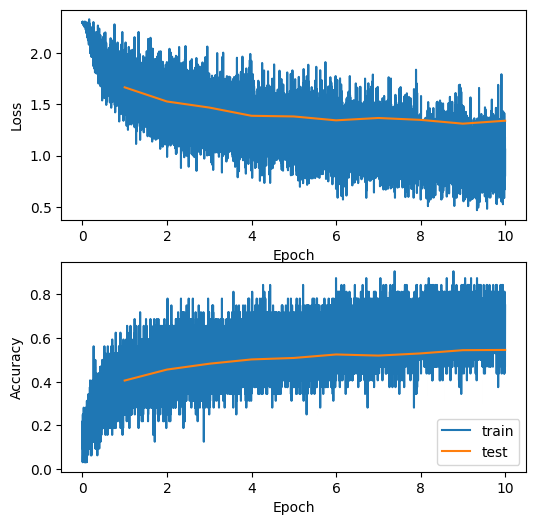

In [73]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
axes[0].plot(train_stats['epoch'], train_stats['loss'], label='train')
axes[0].plot(test_stats['epoch'], test_stats['loss'], label='test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].plot(train_stats['epoch'], train_stats['acc'], label='train')
axes[1].plot(test_stats['epoch'], test_stats['acc'], label='test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.show()

In [103]:
images.view(-1, 3072).shape

torch.Size([81, 3072])

In [108]:
img = images[0].view(1, 3072)

# we are turning off the gradients
with torch.no_grad():
    model_prediction = model.forward(img.to(device))

In [109]:
test_load_all = DataLoader(cifar10_test, batch_size=10000, shuffle=False)

In [110]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.01932935 0.13093795 0.04876088 0.5180617  0.01786091 0.06421012
 0.00503651 0.00133313 0.18387857 0.01059084]


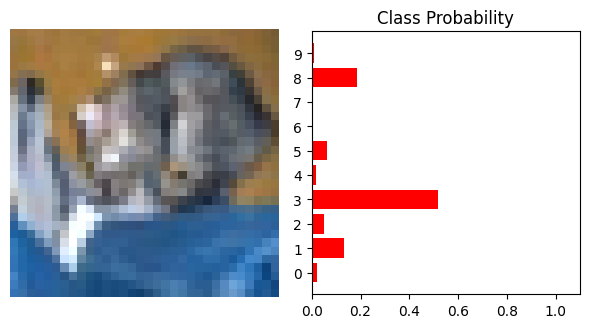

In [111]:
import torch.nn.functional as F 

probabilities = F.softmax(model_prediction, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
curr_img = unnormalize(img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225]))
img = curr_img.view(3, 32, 32)
ax1.imshow(img.permute(1, 2, 0).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

In [79]:
with torch.no_grad():
  print('Training:')
  correct = 0
  samples = 0
  for X_test, y_test in train_loader: 
    y_val = model(X_test.view(len(X_test),-1).to(device))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test.to(device)).sum()
    samples += predicted.size(0)
  print(
            f"Got {correct} from {samples} with accuracy"
            f" {float(correct) / float(samples) * 100:.2f}"
        )

with torch.no_grad():
  print('Test:')
  correct = 0
  samples = 0
  for X_test, y_test in test_load_all: 
    y_val = model(X_test.view(len(X_test),-1).to(device))
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test.to(device)).sum()
    samples += predicted.size(0)
  print(
              f"Got {correct} from {samples} with accuracy"
              f" {float(correct) / float(samples) * 100:.2f}"
          )

Training:
Got 34918 from 50000 with accuracy 69.84
Test:
Got 5457 from 10000 with accuracy 54.57


In [80]:
100*correct.item()/len(cifar10_test)

54.57

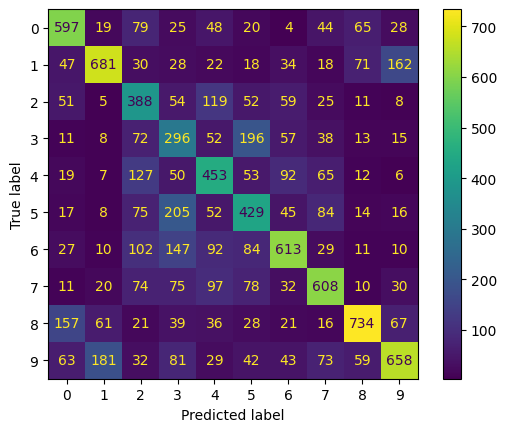

In [81]:
cm = confusion_matrix(predicted.view(-1).cpu(),y_test.view(-1))
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [82]:
#Model accuracy
report = classification_report(predicted.view(-1).cpu(),y_test.view(-1))
print(report)

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       929
           1       0.68      0.61      0.65      1111
           2       0.39      0.50      0.44       772
           3       0.30      0.39      0.34       758
           4       0.45      0.51      0.48       884
           5       0.43      0.45      0.44       945
           6       0.61      0.54      0.58      1125
           7       0.61      0.59      0.60      1035
           8       0.73      0.62      0.67      1180
           9       0.66      0.52      0.58      1261

    accuracy                           0.55     10000
   macro avg       0.55      0.54      0.54     10000
weighted avg       0.57      0.55      0.55     10000



In [83]:
test_load_all = DataLoader(cifar10_test, batch_size=81, shuffle=False)

In [84]:
images, labels = next(iter(test_load_all))

with torch.no_grad():
  images, labels = images, labels
  preds = model(X_test.view(len(X_test),-1).to(device))

images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = cifar10_test.classes

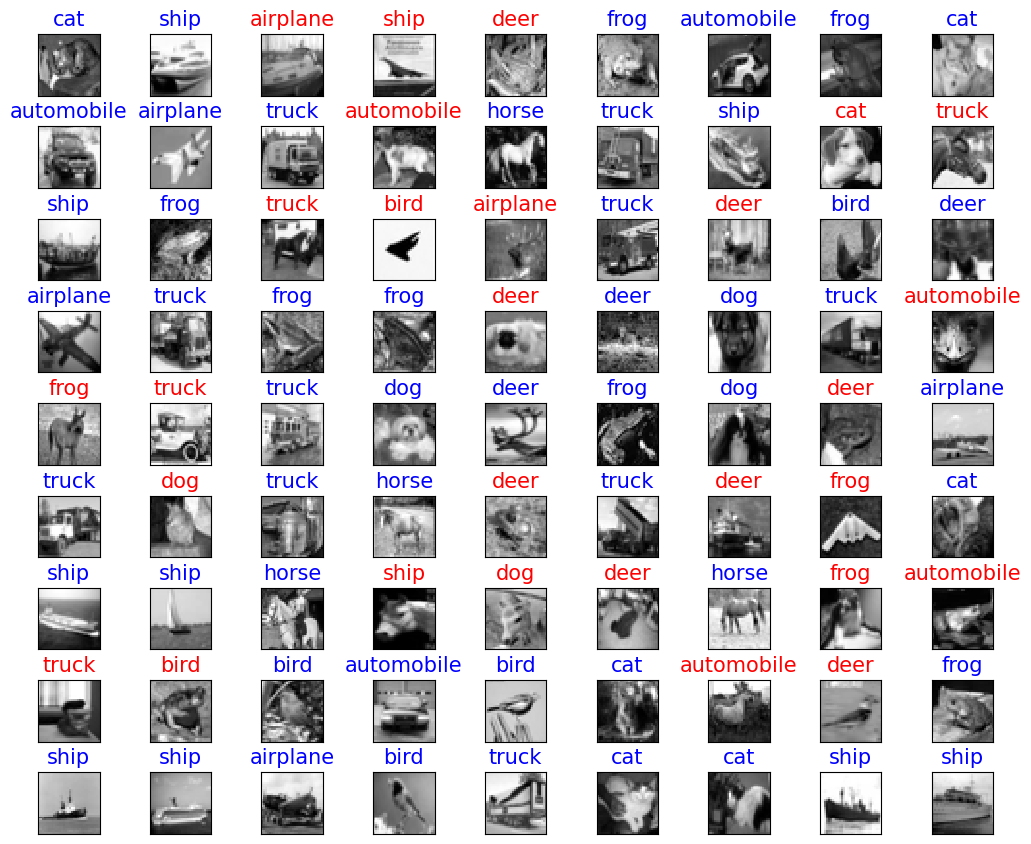

In [85]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap='gray', interpolation='nearest')
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color, fontsize=15)

The ANN model with 4 hidden layers granted the highest accuracy (slightly higher than the model with 3 hidden layers) with overall 5 ~ 10 mins per model